In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer , make_blobs, load_iris
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

import sys
from pathlib import Path

# Añadir el directorio raíz del proyecto al path
root_dir = Path(__file__).resolve().parents[1] if '__file__' in globals() else Path.cwd().parents[0]
sys.path.append(str(root_dir))

# Ahora puedes importar así:
from episcopeenvigado import dataset
# O funciones específicas
from episcopeenvigado.dataset import obtener_dataset_completo


ModuleNotFoundError: No module named 'dotenv'

# Búsqueda en Rejilla y Validación Cruzada

La validación cruzada es un método para evaluar el rendimiento.

La búsqueda en rejilla, es un método para ajustar los parámetros en modelos supervisados ​​y mejorar el rendimiento.

## Validación Cruzada 

Es un método estadístico para evaluar la capacidad de generalización: Los datos se dividen en pliegues (k-fold) y se entrenan múltiples modelos en cada pliegue. 

El primer modelo se entrena utilizando el pliegue 1 como conjunto de prueba, y los pliegues  2-5 como conjunto de entrenamiento. Posteriormente, se construye otro modelo con el pliegue 2 como conjunto de prueba y los datos de los pliegues 1, 3, 4 y 5 como conjunto de entrenamiento, etc. 

In [ ]:
from sklearn.model_selection import cross_val_score 
from sklearn.linear_model import LogisticRegression
iris = load_iris()
logreg = LogisticRegression()
episcope_data = ds.obtener_dataset_completo()

dim_fact = episcope_data["fact_atenciones"] 

print(dim_fact.head)
#Por defecto, k=3
scores = cross_val_score(logreg, iris.data, iris.target, cv=5) 
print("Exactitud de la validación cruzada: {}".format(scores))

NameError: name 'ds' is not defined

### Validación Cruzada estratificada

Para modelos de clasificación, es recomendable utilizar la validación cruzada estratificada: dividimos los datos de manera que las proporciones entre las clases sean las mismas en cada partición que en el conjunto de datos completo.

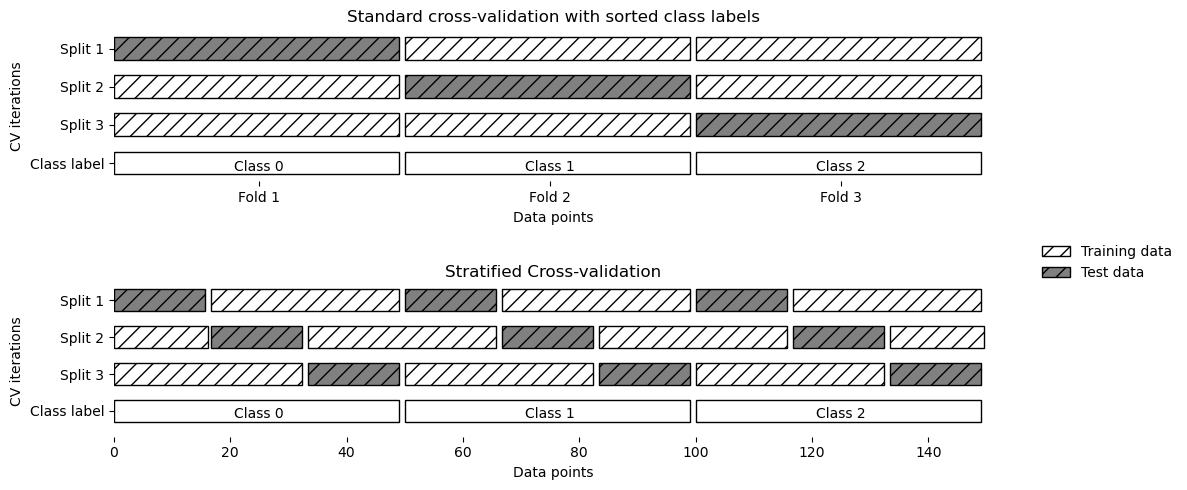

In [16]:
import mglearn
mglearn.plots.plot_stratified_cross_validation()

In [ ]:
print("Iris labels:\n{}".format(iris.target))


Iris labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [ ]:
from sklearn.model_selection import KFold 
kfold = KFold(n_splits=5)
print("Cross-validation scores:\n{}".format( cross_val_score(logreg, iris.data, iris.target, cv=kfold)))



Cross-validation scores:
[1.         1.         0.86666667 0.93333333 0.83333333]


Otra opción es aleatorizar los datos en lugar de estratificar los pliegues, pero debemos fijar `random_state=0`. De lo contrario, cada ejecución de `cross_val_score` arrojaría un resultado diferente, ya que se usaría una división distinta en cada ocasión.

`kfold = KFold(n_splits=3, shuffle=True, random_state=0)`


In [21]:
#leave-one-out: Cada fold representa una sola muestra 
# Para cada división, se selecciona un dato para el conjunto de prueba. (muy lento para grandes datos)
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
scores = cross_val_score(logreg, iris.data, iris.target, cv=loo) 
print("Número de iteraciones sobre cv: ", len(scores))
print("Media del puntaje: {:.2f}".format(scores.mean()))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Número de iteraciones sobre cv:  150
Media del puntaje: 0.97


### Validación cruzada con división aleatoria

Cada división toma puntos para el conjunto de entrenamiento de `train_size` y para el conjunto de prueba de `test_size`. 
Esta división se repite `n_iter` veces. 

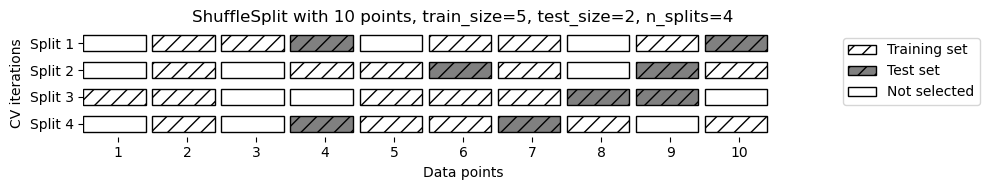

In [ ]:
mglearn.plots.plot_shuffle_split()

In [28]:
from sklearn.model_selection import ShuffleSplit

# Divición del conjunto en 50% para entrenamiento y un 50% para prueba para 10 iteraciones
shuffle_split = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10) 
scores = cross_val_score(logreg, iris.data, iris.target, cv=shuffle_split) 
print("Extactidudes sobre la Validación cruzada:\n{}".format(scores))
print('='*30)
print('También se puede usar solo una parte de los datos en cada iteración\nbasta con dar valores distintos en `train_size` y `test_size`\nEste submuestreo puede ser útil con grandes conjuntos de datos.')


Extactidudes sobre la Validación cruzada:
[0.96       0.96       1.         0.97333333 0.98666667 0.97333333
 0.97333333 0.94666667 0.97333333 0.97333333]
También se puede usar solo una parte de los datos en cada iteración
basta con dar valores distintos en `train_size` y `test_size`
Este submuestreo puede ser útil con grandes conjuntos de datos.


### Validación cruzada con grupos

Cuando existen grupos de datos altamente relacionados, podemos usar `GroupKFold`, que toma como argumento un array que indica los grupos de datos que no deben dividirse al crear los conjuntos de entrenamiento y prueba, y no debe confundirse con la etiqueta de clase.

Este caso es común en aplicaciones médicas, donde se pueden tener múltiples muestras del mismo paciente, pero se busca generalizar a nuevos pacientes. 

In [37]:
from sklearn.model_selection import GroupKFold

X, y = make_blobs(n_samples=12, random_state=0)
# las tres primeras muestras pertenecen al mismo grupo,
# las cuatro siguientes pertenecen al mismo grupo, etc.
groups=[0,0,0,1,1,1,1,2,2,3,3,3]
scores = cross_val_score(estimator=logreg, X=X, y=y, groups=groups, cv=GroupKFold(n_splits=2)) 
print("Extactidudes sobre la Validación cruzada:\n{}".format(scores))


Extactidudes sobre la Validación cruzada:
[0.66666667 0.5       ]


## Búsqueda en Rejilla

Es un método para encontrar los valores de los parámetros para un mejor modelo.

In [ ]:
from sklearn.svm import SVC
svm = SVC()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)


for gamma in [0.001, 0.01, 0.1, 1, 10, 100]: 
        for C in [0.001, 0.01, 0.1, 1, 10, 100]:
            # Para cada combinación de parámetros, entrena SVC.
            svm = SVC(gamma=gamma, C=C)
            svm.fit(X_train, y_train)
            # Evalúa SVC en el conjunto de prueba
            score = svm.score(X_test, y_test)
            # Almacena la puntuación y los parámetros para la mejor puntuación mejor 
            if score > best_score:
                best_score = score
                best_parameters = {'C': C, 'gamma': gamma}

print("Mejor exactitud: {:.2f}".format(best_score)) 
print("Mejores parámetros: {}".format(best_parameters))

Mejor exactitud: 0.97
Mejores parámetros: {'C': 100, 'gamma': 0.001}


### Overfiting

Aunque la precisión sobre los datos de prueba es 97%, no necesariamente la precisión se mantendrá con nuevos datos. 

Dado que usamos los datos de prueba para ajustar los parámetros, ya no podemos usarlos para evaluar la calidad del modelo. Una forma de resolver este problema es dividir los datos nuevamente, de modo que tengamos tres conjuntos: 
1. datos de entrenamiento para construir el modelo
2. datos de validación (o desarrollo) para seleccionar los parámetros del modelo
3. datos de prueba para evaluar el rendimiento de los parámetros seleccionados. 

Seleccionamos los mejores parámetros usando el conjunto de validación y se entrena con los datos de entrenamiento y con los de validación.

In [40]:
# Divisióon train+validation dataset and test dataset
X_trainval, X_test, y_trainval, y_test = train_test_split(iris.data, iris.target, random_state=0)

# División train+validation dataset en training data y validation data  
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=1)
best_score = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]: 
        for C in [0.001, 0.01, 0.1, 1, 10, 100]:
            # Para cada combinación de parámetros, entrena SVC.
            svm = SVC(gamma=gamma, C=C)
            svm.fit(X_train, y_train)
            # Evalúa SVC en el conjunto de prueba 
            score = svm.score(X_valid, y_valid)
            # Almacena la puntuación y los parámetros para la mejor puntuación mejor 
            if score > best_score:
                best_score = score
                best_parameters = {'C': C, 'gamma': gamma}

# Entreanmos el modelo con train+validation dataset y lo evaluamos con test dataset.
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print("Mejor puntaje sobre el conjunti de validación: {:.2f}".format(best_score))
print("Mejores parametros: ", best_parameters)
print("Puntaje sobre datos de prueba con los mejores parametros: {:.2f}".format(test_score))

Mejor puntaje sobre el conjunti de validación: 0.96
Mejores parametros:  {'C': 10, 'gamma': 0.001}
Puntaje sobre datos de prueba con los mejores parametros: 0.92


# Pipelines

In [41]:
from sklearn.pipeline import Pipeline
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=42)

# Pipeline de dos pasos: "scaler" y "svm".
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])
# .fit para usar el pipeline.
pipe.fit(X_train, y_train)
# .score para el puntaje del modelo
print("Test score: {:.2f}".format(pipe.score(X_test, y_test)))

Test score: 0.98


## Pipelines para búsqueda en regillas

In [ ]:
# La sintaxis para definir una grilla de parámetros para un Pipeline: 
# (Nombre del paso)__(nombre del parámetro). 
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
                  'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5) 
grid.fit(X_train, y_train)
print("Mejor exactitud de validación cuzada: {:.2f}".format(grid.best_score_)) 
print("R^2 score: {:.2f}".format(grid.score(X_test, y_test))) 
print("Mejores parámetros: {}".format(grid.best_params_))

Mejor exactitud de validación cuzada: 0.98
Test set score: 0.97
Mejores parámetros: {'svm__C': 1, 'svm__gamma': 1}


## Fuga de información en la validación cruzada

Estimar la escala de los datos mediante el pliegue de prueba no suele tener un impacto significativo, mientras que su uso en la extracción y selección de características puede generar diferencias sustanciales en los resultados.


In [ ]:
# Conjunto de datos, donde no existe relación entre variables
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

In [ ]:
from sklearn.feature_selection import SelectPercentile, f_regression

#SelectPercentile: seleccina la característica del percentil con R^2 más alto
# y entrena el modelo mediante validación cruzada
select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y) 
X_selected = select.transform(X)
print("X_selected.shape: {}".format(X_selected.shape))


X_selected.shape: (100, 500)


In [ ]:
from sklearn.linear_model import Ridge

print("Cross-validation accuracy (cv only on ridge): {:.2f}".format(
    np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))

Cross-validation accuracy (cv only on ridge): 0.91


El $R^2$ indica un modelo muy bueno. **Esto no puede ser correcto**, los datos son aleatorios.

¿Qué sucedió? la selección de características eligió algunas (entre las 10 000 aleatorias), que (por azar) están bien correlacionadas. 

Dado que ajustamos la selección de características fuera de la validación cruzada, pudo encontrar características correlacionadas tanto en el conjunto de entrenamiento como en el de prueba. La información que se filtró del conjunto de prueba fue muy informativa, lo que condujo a resultados muy poco realistas. 

In [11]:
pipe = Pipeline([("select", SelectPercentile(score_func=f_regression,
                                                 percentile=5)),("ridge", Ridge())]) 

print("Cross-validation accuracy (pipeline): {:.2f}".format(
    np.mean(cross_val_score(pipe, X, y, cv=5))))

Cross-validation accuracy (pipeline): -0.25


$R^2$ cercano a cero, un modelo deficiente.

Con el Pipeline la selección de características se encuentra ahora dentro del bucle de validación cruzada. Esto significa que las características solo se pueden seleccionar utilizando los pliegues de entrenamiento de los datos, no el pliegue de prueba. 

Se corrige el problema de fuga de datos en la selección de características y marca la diferencia entre concluir que un modelo funciona muy bien o concluir que no funciona en absoluto.